# Анализ рынка недвижимости СПб
Задача - определить параметры, от которых зависит рыночная стоимость жилья, чтобы сделать на их основе автоматизированную систему поиска аномалий и мошенников. 

## План
1. [Начало работы](#start)
2. [Предобработка данных](#preprocess)
3. [Добавление необходимой информации](#new_inf)
4. [Исследовательский анализ данных](#process)
5. [Выводы](#end)

-----------

# Начало работы
<a name='start'></a>
<a id='start'></a>

Для начала импортируем нужные библиотеки, напишем нужные функции и прочитаем данные в *df*:

In [ ]:
!pip install numpy==1.17.4

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar
import warnings
import seaborn as sns

In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
cmap=sns.diverging_palette(230, 20, as_cmap=True)

In [ ]:
def na_mean(df, all=False):
    """
    По умолчанию возвращает Series с долей пропущенных значений, 
    отсортированный по убыванию и без полей с 0%
    
    Если указан флаг all - возвращает Series с долей пропущенных значений 
    по каждому полю и сообщением "Нет пропусков", если доля равна 0
    """
    if all:
        return (df.isna().mean().map('{:.2%}'
                .format).replace('0.00%', 'Нет пропусков'))
    return (df.isna().mean().loc[lambda x: x != 0]
            .sort_values(ascending=False).map('{:.2%}'.format))
        


In [ ]:
def up_whisker(series):
    """
    Возвращает значение верхней границы из boxplot
    """
    q = series.quantile([0.25, 0.75])
    return q[0.75] + 1.5 * (q[0.75] - q[0.25])

In [ ]:
df = pd.read_csv('/datasets/data.csv', 
                 sep='\t')

Далее выведем информацию о таблице, чтобы составить дальшейший план действий:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

Из сопроводительной информации узнаём о значении каждого поля:
    <details>
- *airports_nearest* — расстояние до ближайшего аэропорта в метрах (м) 
- *balcony* — число балконов
- *ceiling_height* — высота потолков (м)
- *cityCenters_nearest* — расстояние до центра города (м)
- *days_exposition* — сколько дней было размещено объявление (от публикации до снятия)
- *first_day_exposition* — дата публикации
- *floor* — этаж
- *floors_total* — всего этажей в доме
- *is_apartment* — апартаменты (булев тип)
- *kitchen_area* — площадь кухни в квадратных метрах (м²)
- *last_price* — цена на момент снятия с публикации
- *living_area* — жилая площадь в квадратных метрах(м²)
- *locality_name* — название населённого пункта
- *open_plan* — свободная планировка (булев тип)
- *parks_around3000* — число парков в радиусе 3 км
- *parks_nearest* — расстояние до ближайшего парка (м)
- *ponds_around3000* — число водоёмов в радиусе 3 км
- *ponds_nearest* — расстояние до ближайшего водоёма (м)
- *room*s — число комнат
- *studio* — квартира-студия (булев тип)
- *total_area* — площадь квартиры в квадратных метрах (м²)
- *total_images* — число фотографий квартиры в объявлении
    </details>

Дополнительно посмотрим на процент пропусков по каждому полю:

In [ ]:
na_mean(df, 1)

total_images            Нет пропусков
last_price              Нет пропусков
total_area              Нет пропусков
first_day_exposition    Нет пропусков
rooms                   Нет пропусков
ceiling_height                 38.80%
floors_total                    0.36%
living_area                     8.03%
floor                   Нет пропусков
is_apartment                   88.29%
studio                  Нет пропусков
open_plan               Нет пропусков
kitchen_area                    9.61%
balcony                        48.61%
locality_name                   0.21%
airports_nearest               23.38%
cityCenters_nearest            23.29%
parks_around3000               23.28%
parks_nearest                  65.91%
ponds_around3000               23.28%
ponds_nearest                  61.56%
days_exposition                13.42%
dtype: object

Посмотрим, наконец, на сами данные:


In [ ]:
df.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,...,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,...,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,...,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,...,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,...,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,...,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,...,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,...,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,...,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


----

# Предобработка данных 
<a name='preprocess'></a>
<a id='preprocess'></a>

Изучив данные, обозначим направления дальнейшей работы:
- изучить пропуски
- поработать с типами данных и единицами измерения
- поработать с датами
- сделать словарь с населёнными пунктами

## Словарь
Сперва облегчим таблицу и сделаем словарь с населёнными пунктами.

Посмотрим на список уникальных значений:

In [ ]:
print(len(df['locality_name'].unique()))
df['locality_name'].unique()

365


array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Как можем увидеть, есть несколько проблем, которые нужно предварительно исправить: несколько пустых значений (0.2%) и негрубые повторы (разное написание).

Пустые значения полностью удалим из таблицы:



In [ ]:
df = df.dropna(subset=['locality_name']).reset_index(drop=True)
df['locality_name'].isna().sum()

0

Разное написание исправим заменой *ё* на *е* и удалением типа населённого пункта, оставив только названия (убрав слова, начинающиеся с маленькой буквы):

In [ ]:
def only_name(string):
    """
    функция принимает на вход строку с типом и названием населённого пункта 
    и возвращает только название (cлова с большой буквы)
    """
    
    words = string.split(' ')
    result = ''
    
    for word in words:
        if not word[0].islower():
            result = result + word + ' '
    
    return result.strip()

In [ ]:
df['locality_name'] = df['locality_name'].str.replace('ё', 'е')

In [ ]:
df['locality_name'] = df['locality_name'].apply(only_name)
len(df['locality_name'].unique())

305

Таким образом мы сократили размер словаря с 365 значений до 305 (удалив 60 повторов). Осталось создать новый столбец *locality_id* и сделать сам словарь, после чего можно будет удалить столбец *locality_name*

In [ ]:
loc_dict = (df['locality_name']
                                .drop_duplicates()
                                .reset_index(drop=True)
                                .to_frame()
)
loc_dict['loc_id']=loc_dict.index
df = df.merge(loc_dict)
df = df.drop('locality_name', axis=1)
loc_dict.columns = ['loc_name', 'loc_id']
df.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,loc_id
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,0
1,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,0
2,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,0
3,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,0
4,5,7915000.0,71.6,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,...,18.9,2.0,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN,0
5,18,5400000.0,61.0,2017-02-26T00:00:00,3,2.50,9.0,43.6,7,NaN,...,6.5,2.0,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0,0
6,5,5050000.0,39.6,2017-11-16T00:00:00,1,2.67,12.0,20.3,3,NaN,...,8.5,NaN,38357.0,13878.0,1.0,310.0,2.0,553.0,137.0,0
7,16,4650000.0,39.0,2017-11-18T00:00:00,1,NaN,14.0,20.5,5,NaN,...,7.6,1.0,12900.0,14259.0,1.0,590.0,1.0,296.0,19.0,0
8,11,6700000.0,82.0,2017-11-23T00:00:00,3,3.05,5.0,55.6,1,NaN,...,9.0,NaN,22108.0,10698.0,3.0,420.0,0.0,NaN,397.0,0
9,6,4180000.0,36.0,2016-09-09T00:00:00,1,NaN,17.0,16.5,7,NaN,...,11.0,1.0,33564.0,14616.0,0.0,NaN,1.0,859.0,571.0,0


## Даты
Далее займёмся самым простым - создадим столбцы *exp_weekday*, *exp_month* и *exp_year*.

Сначала нужно преобразовать столбец с датой в дату:

In [ ]:
df['first_day_exposition'].head()

0    2019-03-07T00:00:00
1    2015-08-20T00:00:00
2    2015-07-24T00:00:00
3    2018-06-19T00:00:00
4    2019-04-18T00:00:00
Name: first_day_exposition, dtype: object

In [ ]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%d')

In [ ]:
df['exp_weekday'] = df['first_day_exposition'].dt.weekday
df['exp_month'] = df['first_day_exposition'].dt.month
df['exp_year'] = df['first_day_exposition'].dt.year

In [ ]:
df[['first_day_exposition', 'exp_weekday', 'exp_month', 'exp_year']]

,first_day_exposition,exp_weekday,exp_month,exp_year
0,2019-03-07,3,3,2019
1,2015-08-20,3,8,2015
2,2015-07-24,4,7,2015
3,2018-06-19,1,6,2018
4,2019-04-18,3,4,2019
...,...,...,...,...
23645,2018-06-16,5,6,2018
23646,2018-03-15,3,3,2018
23647,2018-02-26,0,2,2018
23648,2017-06-30,4,6,2017


## Пропуски
Посмотрим ещё раз на количество пропусков по столбцам:

In [ ]:
na_mean(df)

is_apartment           88.33%
parks_nearest          65.90%
ponds_nearest          61.59%
balcony                48.68%
ceiling_height         38.73%
airports_nearest       23.40%
cityCenters_nearest    23.30%
ponds_around3000       23.30%
parks_around3000       23.30%
days_exposition        13.45%
kitchen_area            9.59%
living_area             8.03%
floors_total            0.36%
dtype: object

Начнём по порядку. 
- *Is_apartment*, очевидно, означает, что это не апартаменты, можно заполнить False
-*Parks_nearest*, *ponds_nearest* и *airports_nearest*- что совсем рядом есть парки, пруды и аэропорты соответственно (или их вообще нет поблизости) (заполним маркером *-1*)
- *balcony* - что нет балкона, можно заполнить нулём
- *Ceiling_height* - непонятно
- *cityCenters_nearest* - возможно, дело в небольших населённых пунктах (так как отсутствуют ещё и нулевые значения, можно предположить, что пропуски находятся очень близко к центру, можно заполнить нулями, проверим этот момент)
- *Ponds_around3000* и *parks_around3000*, наиболее вероятно, означают что прудов и парков поблизости нет, можно заполнить нулём
- *Days_exposition* может означать, что объявление ещё актуально (заполним маркером -1)
- *Kitchen_area* - возможно, пропуски в студиях
- *Living_area* - непонятно
- *Floors_total* - непонятно, можно удалить

Сравним цены квартир с пропусками в *cityCenters_nearest* в СПб со всеми ценами по СПб, чтобы сделать выводы о значении пропусков:

In [ ]:
def comp_col(series1, series2, name1='1', name2='2'):
    return(
        series1.describe().map('{0:,.2f}'.format).to_frame(name1).join(
        series2.describe().map('{0:,.2f}'.format).to_frame(name2))
    )

In [ ]:
def comp_col_auto(series_list, name_list):
    result = (series_list.pop(0)
                         .describe()
                         .map('{0:,.2f}'.format)
                         .to_frame(name_list.pop(0))
             )
    for series in series_list:
        result = result.join(series.describe()
                                    .map('{0:,.2f}'.format)
                                    .to_frame(name_list.pop(0))
                             )

    return result

~~Просто из интереса закопался в это всё)~~

In [ ]:
comp_col_auto(
    [df[(df['cityCenters_nearest'].isna())&(df['loc_id']==0)]['last_price'],
    df[df['loc_id']==0]['last_price']],
    ['Центр?', 'Весь Питер']
)
# df[
#    (df['cityCenters_nearest'].isna())&(df['loc_id']==0)
#    ]['last_price'].describe().map('{0:,.2f}'.format).to_frame('Центр?').join\
# (df[
#     df['loc_id']==0
#     ]['last_price'].describe().map('{0:,.2f}'.format).to_frame('Весь Питер'))

,Центр?,Весь Питер
count,61.00,"15,721.00"
mean,"15,693,287.93","8,062,507.07"
std,"20,133,229.07","13,013,133.29"
min,"3,100,000.00","12,190.00"
25%,"5,590,000.00","4,200,000.00"
50%,"8,600,000.00","5,500,000.00"
75%,"14,990,000.00","8,160,000.00"
max,"130,000,000.00","763,000,000.00"


Как мы видим, средняя и медианная цена с пропусками выше, чем по всему Питеру. Думаю, можно допустить истинность нашего предположения и заменить пропуски нулями

Обработаем очевидные пропуски:

In [ ]:
df['is_apartment'] = df['is_apartment'].fillna(False)

for column in \
['balcony', 'ponds_around3000', 'parks_around3000', 'cityCenters_nearest']:
   df[column] = df[column].fillna(0)

for column in \
['parks_nearest', 'ponds_nearest', 'airports_nearest', 'days_exposition']:
    df[column] = df[column].fillna(-1)

Обработаем пропуски в полях, нужных для работы.

Построим тепловую карту корреляции столбца *living_area*, чтобы определиться со способом заполнения пропусков:

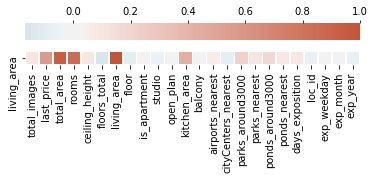

In [ ]:
sns.heatmap(df.corr()['living_area'].to_frame().T, 
            cmap=cmap, 
            center=0, 
            square=True, 
            linewidths=.5, 
            cbar_kws = dict(use_gridspec=False,location="top"))
plt.show()
plt.close()

Как видно, *living_area* коррелирует с *total_area* и с *rooms*. Заполним пропуски медианными значениями по количеству комнат в каждом населённом пункте: 

In [ ]:
df['living_area'] = (df['living_area']
                    .fillna(df.groupby(['loc_id', 'rooms'])['living_area']
                    .transform('median'))
                    )
df['living_area'].isna().sum()

52

Оставшиеся пропуски заполним просто медианой по числу комнат:

In [ ]:
df['living_area'] = df['living_area'].fillna(
    df.groupby('rooms')['living_area'].transform('median')
)
na_mean(df, 1)['living_area']

'Нет пропусков'

Взглянем на *kitchen_area*:

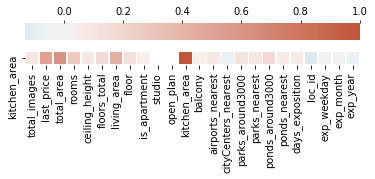

In [ ]:
sns.heatmap(df.corr()['kitchen_area'].to_frame().T, 
            cmap=cmap, 
            center=0, 
            square=True, 
            linewidths=.5, 
            cbar_kws = dict(use_gridspec=False,location="top"))
plt.show()
plt.close()

*kitchen_area* с количеством комнат уже не коррелирует, поэтому поступим по другому - заполним пропущенные значения с помощью средних отношений площади кухни к общей площади, сгруппированных по количеству комнат в каждом населённом пункте:

In [ ]:
df['temp'] = df['kitchen_area'] / df['total_area']
df['temp'] = df.groupby(['loc_id', 'rooms'])['temp'].transform('median')
df['temp'] = df['temp'].fillna(df['temp'].mean())

In [ ]:
df['kitchen_area'] = df['kitchen_area'].fillna(df['total_area'] * df['temp'])
df = df.drop('temp', axis=1)

In [ ]:
na_mean(df, 1)['kitchen_area']

'Нет пропусков'

In [ ]:
#df['kitchen_area'].hist(bins='auto', range=(0, 20))

In [ ]:
# df['kitchen_area'] = (df['kitchen_area']
#                      .fillna(df.groupby(['loc_id', 'rooms'])['kitchen_area']
#                      .transform('median'))
#                      )
# df['kitchen_area'] = (df['kitchen_area']
#                      .fillna(df.groupby('rooms')['kitchen_area']
#                      .transform('median')))
# na_mean(df, 1)['kitchen_area']
# df['kitchen_area'].isna().sum()

Оставшиеся строки удалим:

*ceiling_height* заполним модой по количеству этажей в доме в каждом населённом пункте, учтя свободную планировку(сперва удалив пропуски в *floors_total*:

In [ ]:
df = df.dropna(subset=['floors_total'])

df['ceiling_height'] = (df['ceiling_height']
                     .fillna(df.groupby(['loc_id', 'floors_total', 'open_plan'])['ceiling_height']
                     .transform(lambda x: x.mode().array[-1] if not x.mode().empty else -1))
                     )

In [ ]:
na_mean(df, 1)

total_images            Нет пропусков
last_price              Нет пропусков
total_area              Нет пропусков
first_day_exposition    Нет пропусков
rooms                   Нет пропусков
ceiling_height          Нет пропусков
floors_total            Нет пропусков
living_area             Нет пропусков
floor                   Нет пропусков
is_apartment            Нет пропусков
studio                  Нет пропусков
open_plan               Нет пропусков
kitchen_area            Нет пропусков
balcony                 Нет пропусков
airports_nearest        Нет пропусков
cityCenters_nearest     Нет пропусков
parks_around3000        Нет пропусков
parks_nearest           Нет пропусков
ponds_around3000        Нет пропусков
ponds_nearest           Нет пропусков
days_exposition         Нет пропусков
loc_id                  Нет пропусков
exp_weekday             Нет пропусков
exp_month               Нет пропусков
exp_year                Нет пропусков
dtype: object

## Типы данных
Посмотрим на типы данных:

In [ ]:
df.dtypes

total_images                     int64
last_price                     float64
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                   float64
living_area                    float64
floor                            int64
is_apartment                      bool
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                        float64
airports_nearest               float64
cityCenters_nearest            float64
parks_around3000               float64
parks_nearest                  float64
ponds_around3000               float64
ponds_nearest                  float64
days_exposition                float64
loc_id                           int64
exp_weekday                      int64
exp_month                        int64
exp_year                         int64
dtype: object

Приведём все числовые поля, кроме *ceiling_height*, к типу *int*:

In [ ]:
for col in df.select_dtypes('float64').columns:
    if not df[col].isna().sum():
        if col == 'ceiling_height':
            continue
        df[col] = df[col].astype('int')

df.dtypes

total_images                     int64
last_price                       int64
total_area                       int64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                     int64
living_area                      int64
floor                            int64
is_apartment                      bool
studio                            bool
open_plan                         bool
kitchen_area                     int64
balcony                          int64
airports_nearest                 int64
cityCenters_nearest              int64
parks_around3000                 int64
parks_nearest                    int64
ponds_around3000                 int64
ponds_nearest                    int64
days_exposition                  int64
loc_id                           int64
exp_weekday                      int64
exp_month                        int64
exp_year                         int64
dtype: object



---



# Добавление необходимой информации 
<a name='new_inf'></a>
<a id='new_inf'></a>


Для дальнейших исследований нужно добавить новые поля:
- *price_m2* с ценой квадратного метра
- *liv/total* с отнощением жилой площади квартиры к общей
- *kit/total* с отношением кухонной площади квартиры к общей
- *where_floor* с обозначением этажей *первый*, *последний*, *другой*

Так как со всеми пропусками мы разобрались, первые три получим простым делением:

In [ ]:
df['price_m2'] = df['last_price'] / df['total_area']
df['liv_total'] = df['living_area'] / df['total_area']
df['kit_total'] = df['kitchen_area'] / df['total_area']

А столбец с этажом квартиры создадим с помощью функции:

In [ ]:
df['where_floor'] = (df[['floor', 'floors_total']]
                     .apply(lambda x: 'первый' if x['floor'] == 1 
                            else 'последний' if x['floor'] == x['floors_total'] 
                            else 'другой', axis=1))

Также для удобства разделим поле *last_price* на 1000000:

In [ ]:
df['last_price'] = df['last_price'] / 1000000



---



# Исследовательский анализ данных
<a name='process'></a>
<a id='process'></a>

Чтобы выполнить задачу, нужно проанализировать данные:
- построить гистограммы и изучить основные метрики (площадь, цена, число комнат, высота потолков)
- изучить время продажи квартир
- отфильтровать выбросы

Построим гистограммы для основных метрик, нарисовав для наглядности линию верхней границы диаграммы размаха:

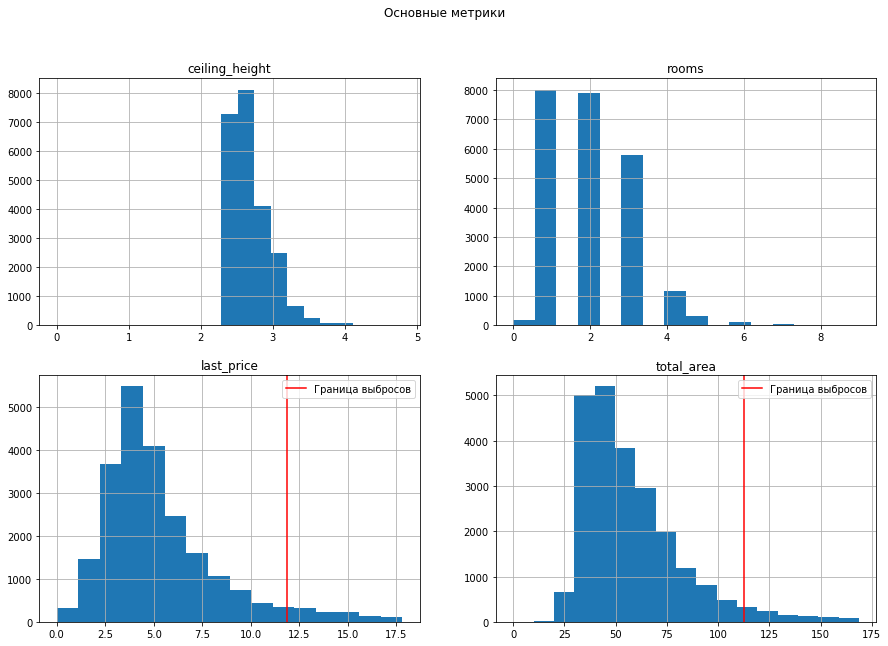

In [ ]:
fig, axes = plt.subplots(2, 2)

fig.set_size_inches(15, 10)
plt.suptitle('Основные метрики')

col=['total_area', 'last_price', 'rooms', 'ceiling_height']

for ax in axes.flat:
    name = col.pop()
    whisk = up_whisker(df[name])
    ax.set_title(name)
    ax.grid()
    if not name in ['rooms', 'ceiling_height']:
        ax.axvline(whisk, color='r', label='Граница выбросов')
        ax.legend()
    ax.hist(df[name], bins='sturges', range=(0, whisk*1.5))
    
plt.show()
plt.close()

Как мы видим, распределения похожи на распределение Пуассона, что является ожидаемым. Изучим время продажи квартиры:

count    20394.000000
mean       180.741395
std        219.732782
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

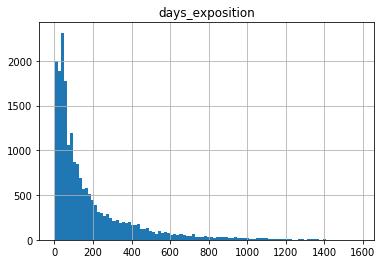

In [ ]:
x = df.loc[df['days_exposition']!=-1, 'days_exposition']
x.hist(bins=100)
plt.title(x.name)
x.describe()

Как можно заметить, среднее время продажи квартиры составляет 180 дней, но медианное почти в два раза меньше - 96. Отфильтруем от выбросов и взглянем ещё раз:

count    16751.000000
mean       127.815832
std        114.767036
min          1.000000
25%         35.000000
50%         92.000000
75%        187.000000
max        461.000000
Name: days_exposition, dtype: float64

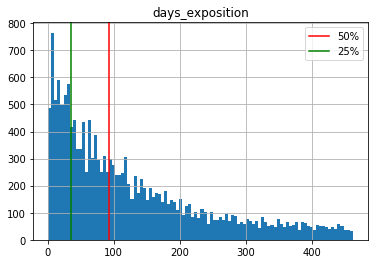

In [ ]:
x = df.loc[(~(df['days_exposition'].isin([-1, 45, 60, 90])) &
        (df['days_exposition']<up_whisker(df['days_exposition']))), 
        'days_exposition']
x.hist(bins=100)
# x.plot.kde()
# plt.axvline(x.mean(), color='green', label='Среднее значение')
plt.axvline(x.median(), color='red', label='50%')
plt.axvline(x.quantile(.25), color='green', label='25%')

plt.title(x.name)
plt.legend()
x.describe()

Мы избавились от очень долгих продаж и странных пиков на 45, 60 и 90 днях (возможно, столько дней действую какие-нибудь платные опции), и стандартное отклонение снизилось почти в два раза, хотя медиана почти не изменилась. 

25% всех объявлений было закрыто в срок до 35 дней. Если нарисовать линию, то с ней видно "ступеньку", отделяющую быстрые сделки от долгих. Думаю, можно назвать все сделки, которые закрылись до 35 дней, быстрыми.

Добавим столбцы с маркером для фильтрации столбцов в будущем:

In [ ]:
for col in df.select_dtypes(['int', 'float']):
    df[col+'_filtered'] = df[col] < up_whisker(df[col])

df['cityCenters_nearest_filtered'] =\
(df['cityCenters_nearest'] < up_whisker(df['cityCenters_nearest']))&\
~(df['cityCenters_nearest'].isin([0]))

df['days_exposition_filtered'] = \
(df['days_exposition'] < up_whisker(df['days_exposition']))&\
~(df['days_exposition'].isin([-1, 45, 60, 90]))

Взглянем на матрицу рассеяния и корреляции по колонкам *'total_area', 'cityCenters_nearest', 'days_exposition', 'price_m2', 'last_price'*, сначала не отфильтрованные:

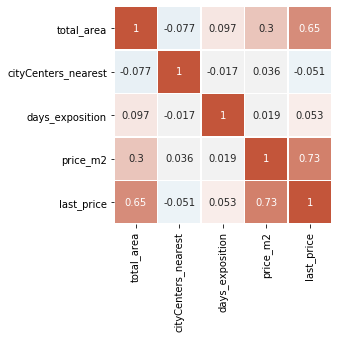

In [ ]:
x = df[['total_area', 
        'cityCenters_nearest', 
        'days_exposition', 
        'price_m2', 
        'last_price']]

sns.heatmap(x.corr(), 
            cmap=cmap, 
            center=0, 
            square=True, 
            linewidths=.5, 
            annot=True,
            cbar=None)
plt.show()
plt.close()

23565

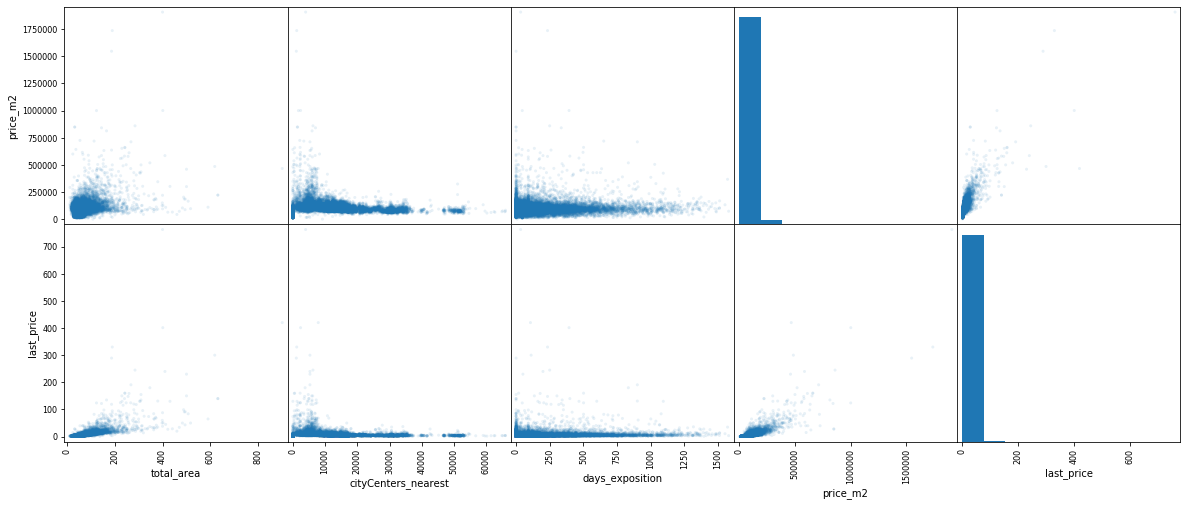

In [ ]:
axes = pd.plotting.scatter_matrix(x, figsize=(20, 20), alpha=0.1)
for ax in axes.flat:
    if ax.get_ylabel() not in ['last_price', 'price_m2']:
        ax.set_visible(False)
len(x)

И сравним с отфильтрованными выбросами:

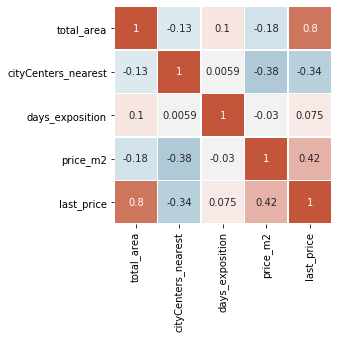

In [ ]:
x = df.query(
    'total_area_filtered and cityCenters_nearest_filtered and \
    days_exposition_filtered and price_m2_filtered and last_price_filtered'
)[['total_area', 
   'cityCenters_nearest', 
   'days_exposition', 
   'price_m2', 
   'last_price']]

sns.heatmap(x.corr(), 
            cmap=cmap, 
            center=0, 
            square=True, 
            linewidths=.5, 
            annot=True,
            cbar=None)
plt.show()
plt.close()

11484

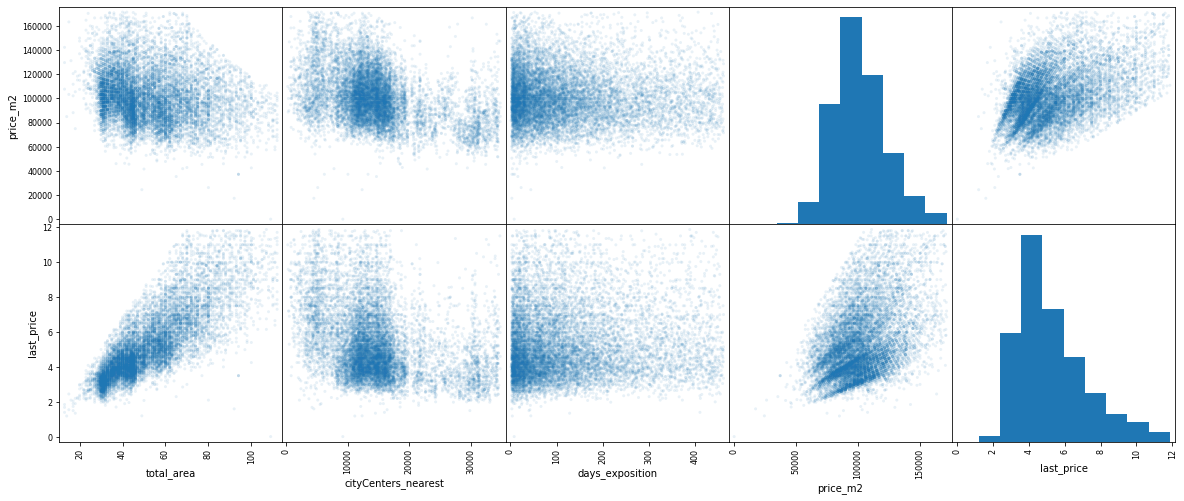

In [ ]:
axes = pd.plotting.scatter_matrix(x, alpha=0.1, figsize=(20, 20))
for ax in axes.flat:
    if ax.get_ylabel() not in ['last_price', 'price_m2']:
        ax.set_visible(False)
len(x)

Мы потеряли большое количество объявлений(примерно половину), зато получили чистые результаты, на которых уже можно увидеть некоторые закономерности. 
Так, на цену квартиры очень сильно влияет её общая площадь, а расстояние до цетнтра имеет небольшую обратную корреляцию. Цена за квадратный метр примерно одинаково зависит от расстояния до центра и цены (судя по матрице корреляции), что говорит о том, что она будет примерно равная внутри одного района. Так же заметно, что если объявление висит долго, цена на него немного снижается.

Рассмотрим другие метрики, такие как зависимость средней цены от дня недели, месяца и года старта продаж:

In [ ]:
def plot_mwy(df, fig_=None, name=None):
    if fig_:
        fig = fig_
    else:
        fig = plt.figure()

    fig.set_size_inches(15, 8)
    fig.set_dpi(90)

    ax1 = fig.add_subplot(2, 1, 1)
    ax2 = fig.add_subplot(2, 2, 3)
    ax3 = fig.add_subplot(2, 2, 4)
    axes = [ax1, ax2, ax3]

    columns = ['exp_month', 'exp_weekday', 'exp_year']

    if name:
        plt.ylim(auto=True)
    for ax in axes:
        column=columns.pop(0)
        x = (df
            .pivot_table(index=column, values='last_price', aggfunc='mean')
            )
        if column == 'exp_month':
            x.index = calendar.month_abbr[1:13]
        if column == 'exp_weekday':
            x.index = calendar.day_abbr[0:7]
        ax.plot(x, marker='o', label=name)
        ax.set_ylabel('Avg price, M')
        if not name:
            ax.set_ylim(0, x['last_price'].max()*1.5)
        ax.set_title('Avg price per ' + column.split('_')[-1])
        ax.grid()
        if name:
            ax.legend()


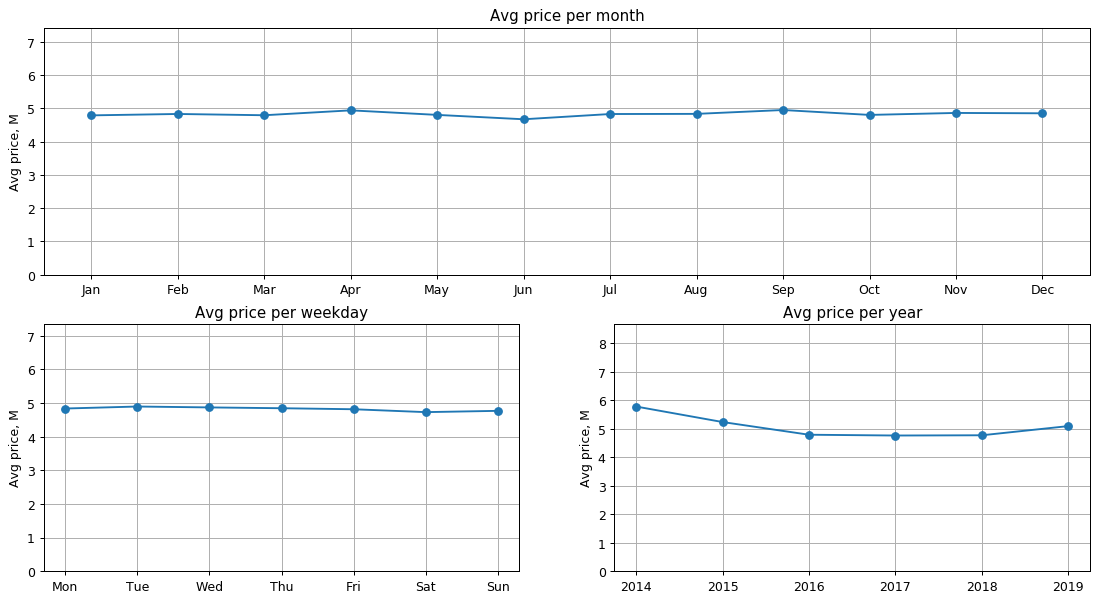

In [ ]:
plot_mwy(df.query('last_price_filtered'))

Видно, то к выходным цены немного снижаются, а так же снижаются в сезон отпусков (в июне и октябре), тогда так перед ними цены самые высокие (в апреле и сентябре).  
После кризиса 2014 года цены закономерно шли вниз, пока в 2016 падение не заменилось движением вбок, и к 2019 году цены уже пошли вверх.

Так же взглянем на средние цены в зависимость от этажа и числа комнат:

In [ ]:
def plot_fr(df, fig_=None, name=None):
    if fig_:
        fig = fig_
    else:
        fig = plt.figure()

    fig.set_size_inches(10, 8)
    fig.set_dpi(90)
    

    ax1 = fig.add_subplot(2, 1, 1)
    ax2 = fig.add_subplot(2, 1, 2)
    axes = [ax1, ax2]
    if name:
        plt.ylim(auto=True)

    columns = ['where_floor', 'rooms']
    for ax in axes:
        column=columns.pop(0)
        x = (df
            .pivot_table(index=column, values='last_price', aggfunc='mean')
            )
        ax.plot(x, marker='o', label=name)
        if not name:
            ax.set_ylim(0, x['last_price'].max()*1.5)
        ax.set_ylabel('Avg price, M')
        ax.set_title('Avg price per ' + column.split('_')[-1])
        ax.grid()
        if name:
            ax.legend()
        


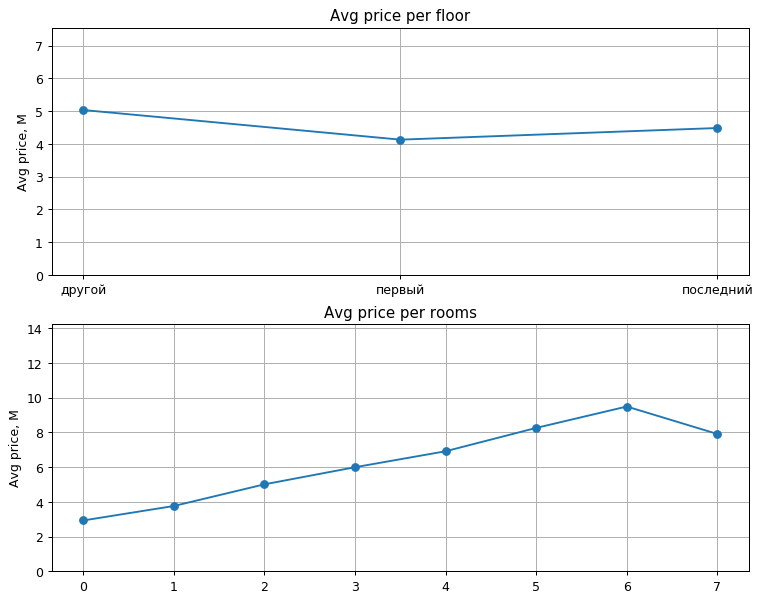

In [ ]:
plot_fr(df.query('last_price_filtered'))

Первый этаж самый невостребованный, следом за ним идёт последний, и самый дорогой любой другой этаж.

Количество комнат напрямую влияет на стоимость, пока их не станет больше 7, где рост цены сменяется резким падением почти на 2 миллиона.

Посмотрим на 10 самых дорогих населённых пунктов:

In [ ]:
(df.query('last_price_filtered')
.merge(loc_dict)
.pivot_table(index='loc_name', values='last_price', aggfunc=['mean', 'count'])
.sort_values(('mean', 'last_price'), ascending=False)
.head(10)
)

,mean,count
,last_price,last_price
loc_name,,
Хязельки,11.000000,1
Репино,6.889139,3
Сестрорецк,5.707094,171
Санкт-Петербург,5.663170,13676
Пушкин,5.334385,338
Зеленогорск,5.032164,22
Заневка,4.781500,6
Мистолово,4.770114,11


И на 10 самых дешёвых:

In [ ]:
(df.query('last_price_filtered')
.merge(loc_dict)
.pivot_table(index='loc_name', values='last_price', aggfunc=['mean', 'count'])
.sort_values(('mean', 'last_price'))
.head(10)
)

,mean,count
,last_price,last_price
loc_name,,
Вахнова Кара,0.4500,1
Старополье,0.4600,3
Бор,0.5000,1
Чудской Бор,0.5000,1
Совхозный,0.5175,2
Свирь,0.5750,2
Выскатка,0.5850,2
Ям-Тесово,0.6250,2


А так же на 10 населённых пунктов с самым большим количеством объявлений:

In [ ]:
(df.query('last_price_filtered')
.merge(loc_dict)
.pivot_table(index='loc_name', values='last_price', aggfunc='count')
.sort_values('last_price', ascending=False)
.head(10)
)

,last_price
loc_name,
Санкт-Петербург,13676
Мурино,586
Кудрово,468
Шушары,439
Всеволожск,397
Пушкин,338
Колпино,336
Парголово,327
Гатчина,305


Посмотрим на данные только по СПб. Сперва отфильтруем их в отдельную таблицу, и попытаемся вычислить центр. Для этого создадим столбец с расстоянием до центра в километрах, приведём к типу *int*, и построим график с зависимостью цены от расстояния до центра:

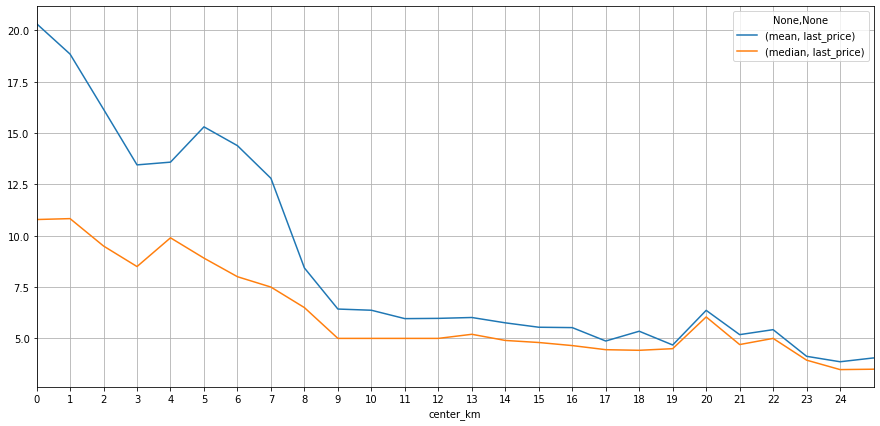

In [ ]:
spb = df.query('loc_id==0').copy()
spb['center_km'] = (spb['cityCenters_nearest'] / 1000).astype('int')
spb.pivot_table(index='center_km', 
                values='last_price', 
                aggfunc=['mean', 'median']).plot(grid=True, figsize=(15, 7), xlim=(0, 25))
plt.xticks(range(25))
plt.show()
plt.close()

Видим явный спад цен после 9 км. Значит центром считается всё, что удалено не более чем на 9 километров. Отметим квартиры, находящиеся в центре:

In [ ]:
spb['is_center'] = spb['center_km'] <= 9

Интересно так же, что после 19 километров цены опять идут вверх. Возможно, дело в спальных районах на окраинах города (какие-то объявления отмечены конкретными районами, а какие-то просто СПб)

Так же обновим фильтрацию выбросов:

In [ ]:
for col in spb.select_dtypes(['int64', 'float64']):
    spb[col+'_filtered'] = spb[col] < up_whisker(spb[col])

spb['days_exposition_filtered'] = (spb['days_exposition'] < up_whisker(spb['days_exposition']))&\
~(spb['days_exposition'].isin([-1, 45, 60, 90]))

Взглянем на матрицы рассеяния:

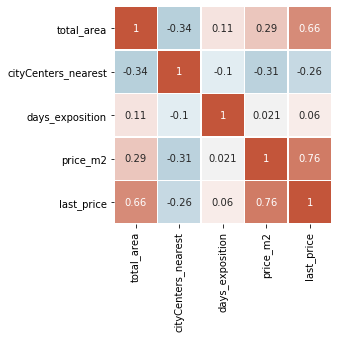

In [ ]:
x = spb[['total_area', 
        'cityCenters_nearest', 
        'days_exposition', 
        'price_m2', 
        'last_price']]

sns.heatmap(x.corr(), 
            cmap=cmap, 
            center=0, 
            square=True, 
            linewidths=.5, 
            annot=True,
            cbar=None)
plt.show()
plt.close()

15651

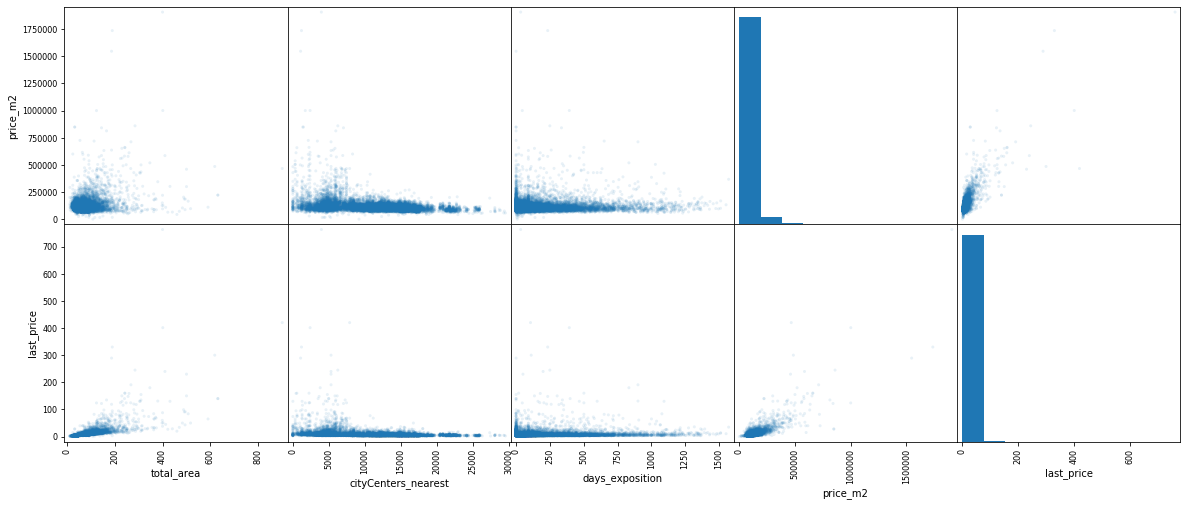

In [ ]:
axes = pd.plotting.scatter_matrix(x, figsize=(20, 20), alpha=0.1)

for ax in axes.flat:
    if ax.get_ylabel() not in ['last_price', 'price_m2']:
        ax.set_visible(False)
        
len(x)

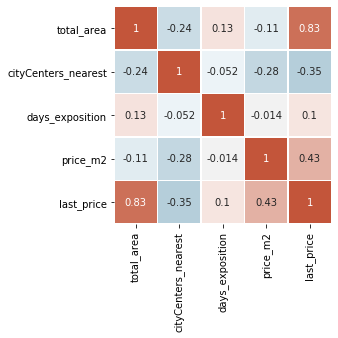

In [ ]:
x = spb.query(
    'total_area_filtered and cityCenters_nearest_filtered and \
    days_exposition_filtered and price_m2_filtered and last_price_filtered'
)[['total_area', 
   'cityCenters_nearest', 
   'days_exposition', 
   'price_m2', 
   'last_price']]

sns.heatmap(x.corr(), 
            cmap=cmap, 
            center=0, 
            square=True, 
            linewidths=.5, 
            annot=True,
            cbar=None)
plt.show()
plt.close()

10303

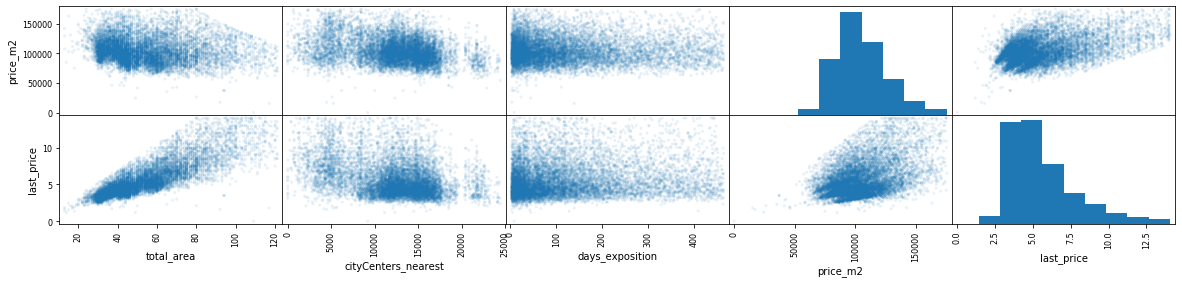

In [ ]:
axes = pd.plotting.scatter_matrix(x, figsize=(20, 10), alpha=0.1)

for ax in axes.flat:
    if ax.get_ylabel() not in ['last_price', 'price_m2']:
        ax.set_visible(False)

len(x)

Наблюдается примерно та же картина, что и при сравнении всех объявлений, только больше видно влияние удалённости от центра и более линейная зависимость цены от площади квартиры. Посмотрим на сравнение других метрик:

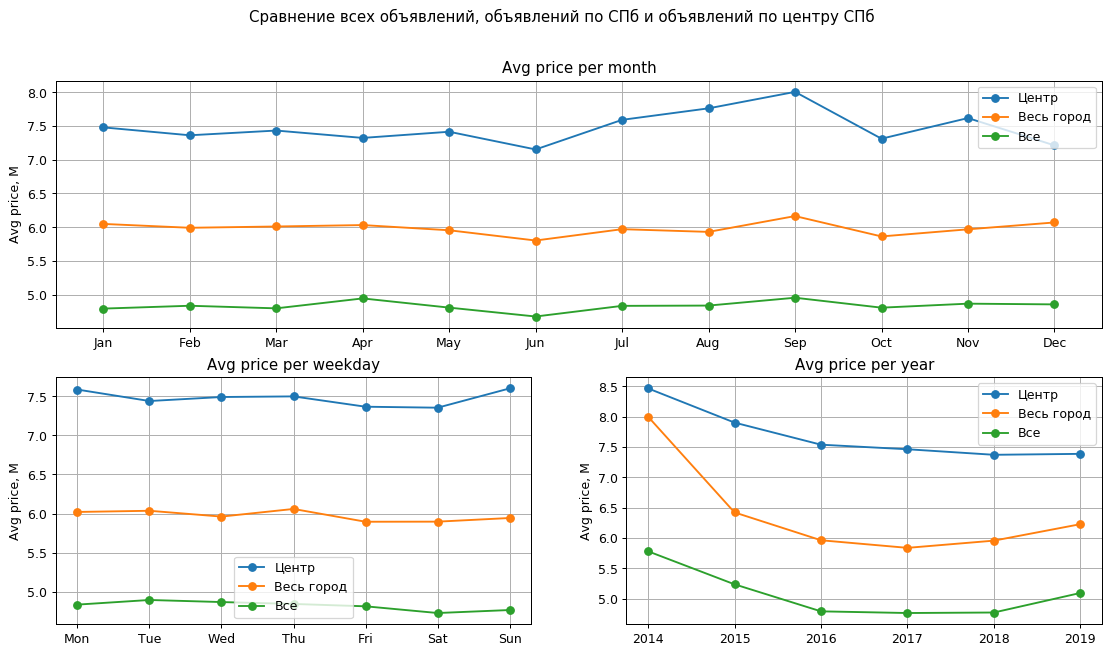

In [ ]:
fig = plt.figure()
plt.suptitle('Сравнение всех объявлений, объявлений по СПб и объявлений по центру СПб')
plot_mwy(spb.query('last_price_filtered and is_center'), fig_=fig, name='Центр')
plot_mwy(spb.query('last_price_filtered'), fig_=fig, name='Весь город')
plot_mwy(df.query('last_price_filtered'), fig_=fig, name='Все')
plt.show()
plt.close()

Мы видим, что тут картина немного отличается. Средняя цена квартиры в Питере после кризиса 2014 года упала намного сильней, чем в области или в центре города. Так же в центре цены до сих пор снижаются, тогда как в городе и области уже начали расти.

Так же в центре почему-то сильно растут цены к осени, и падают к новому году.

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

С предупреждениями также стоит разобраться. Иногда их бывает слишком много, поэтому важно уметь их скрывать. В этом тебе поможет библиотека warnings. Попробуй найти подходящий метод и убрать предупреждения.  

</div>
<div class="alert alert-info" role="alert"> 
Пока отключил предупреждения влоб, но обязательно с ними разберусь, спасибо за наводку)
</div>

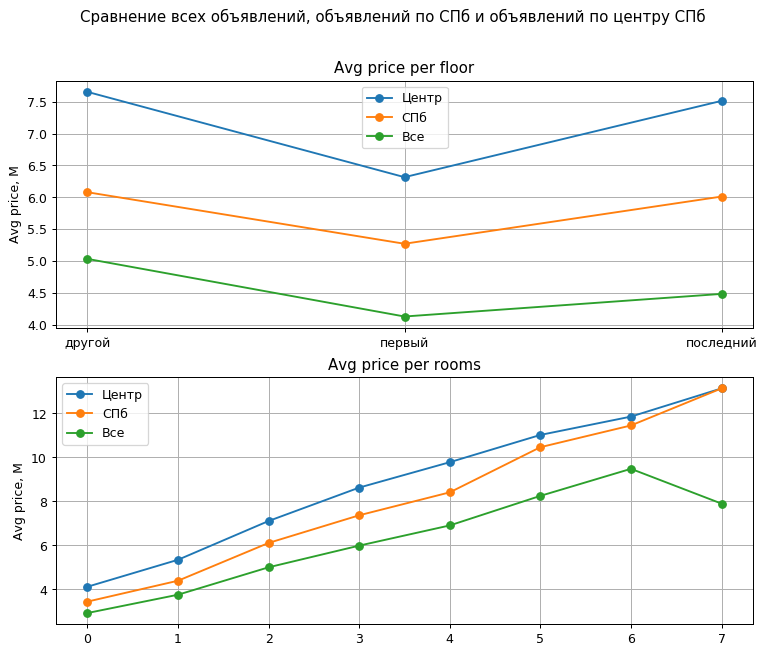

In [ ]:
fig = plt.figure()
plt.suptitle('Сравнение всех объявлений, объявлений по СПб и объявлений по центру СПб')
plot_fr(spb.query('last_price_filtered and is_center'), fig_=fig, name='Центр')
plot_fr(spb.query('last_price_filtered'), fig_=fig, name='СПб')
plot_fr(df.query('last_price_filtered'), fig_=fig, name='Все')
plt.show()
plt.close()

Вцентре Питера максимальное влияние этажа квартиры на цену - между первым и последним средняя разница больше миллиона, тогда как среди всех объявлений она составляет меньше пятисот тысяч. Так же в Питере, независимо от нахождения в центре, продолжают быть востребованными квартиры с 7 комнатами (возможно, это связано с обилием коммунальных квартир)

In [ ]:
def plot_comp(df, column, scatter=False, alpha_=0.8):
    x_all = (df
            .pivot_table(index=column, values='last_price', aggfunc='mean')
            )
    
    x_center = (df.query('is_center')
            .pivot_table(index=column, values='last_price', aggfunc='mean')
            )
    
    fig = plt.figure()

    ax = fig.add_subplot()
    
    if scatter:
        ax.scatter(x=x_all.index, y=x_all['last_price'], label='Весь город', alpha=alpha_)
        ax.scatter(x=x_center.index, y=x_center['last_price'], label='Центр', alpha=alpha_)
    else:
        ax.plot(x_all, marker='o', label='Весь город', alpha=alpha_)
        ax.plot(x_center, marker='o', label='Центр', alpha=alpha_)
    ax.set_title(column)
    ax.set_ylabel('Avg price, M')
    ax.grid()
    ax.legend()
    ax.set_ylim(bottom=0)
    
    plt.show()
    plt.close()
    
    print(f"Корреляция {column} {x_all['last_price'].corr(x_center['last_price'])}")

Построим все графики для поиска неочевидных закономерностей между центром СПб и всем городом:

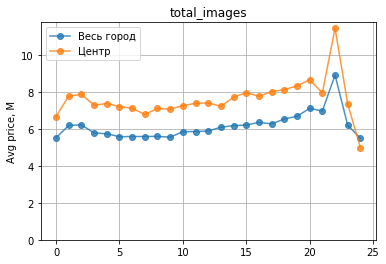

Корреляция total_images 0.9115894391420113


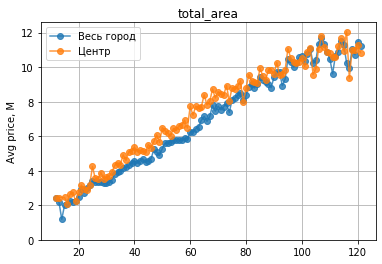

Корреляция total_area 0.9884543712601555


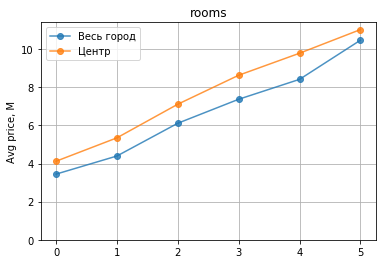

Корреляция rooms 0.9928335962505237


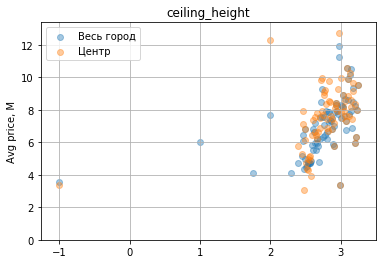

Корреляция ceiling_height 0.863612633609244


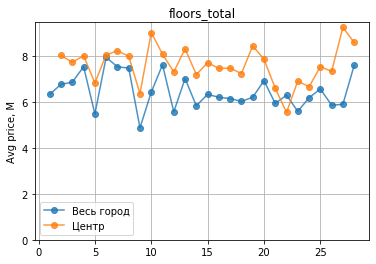

Корреляция floors_total 0.5212250439162877


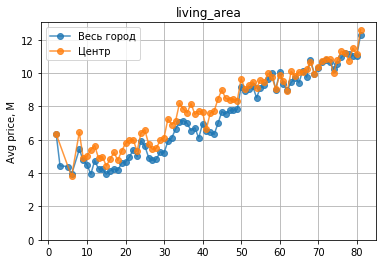

Корреляция living_area 0.9842019767776033


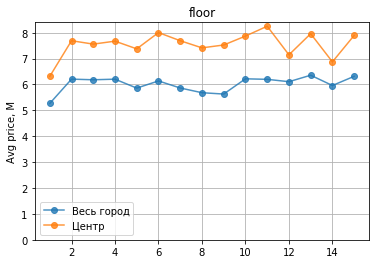

Корреляция floor 0.7412900551619301


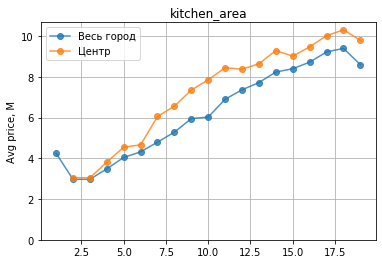

Корреляция kitchen_area 0.9834443576336709


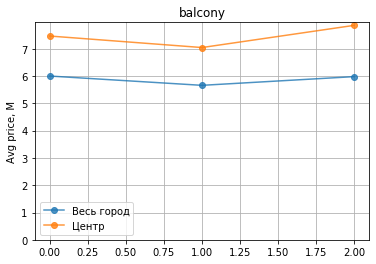

Корреляция balcony 0.84856748786279


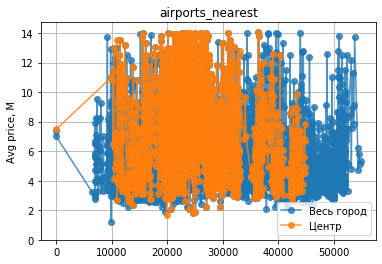

Корреляция airports_nearest 0.9703507435806684


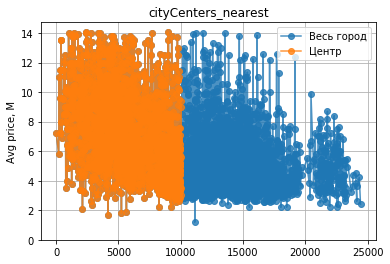

Корреляция cityCenters_nearest 0.9999999999999998


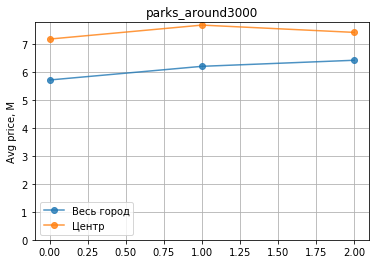

Корреляция parks_around3000 0.6568046203544022


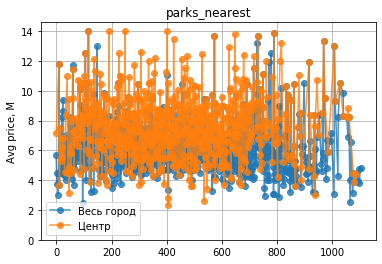

Корреляция parks_nearest 0.6701100179285236


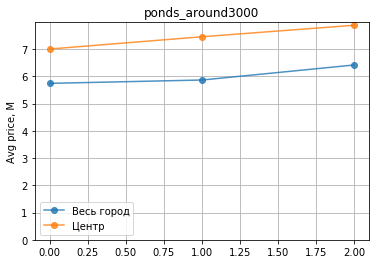

Корреляция ponds_around3000 0.9320334217217924


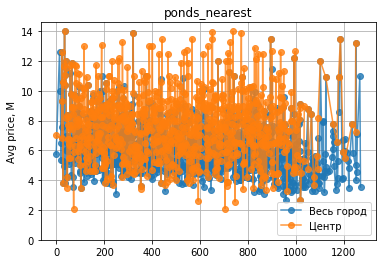

Корреляция ponds_nearest 0.6326250790634658


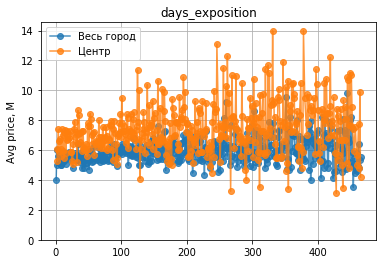

Корреляция days_exposition 0.5813432155566284


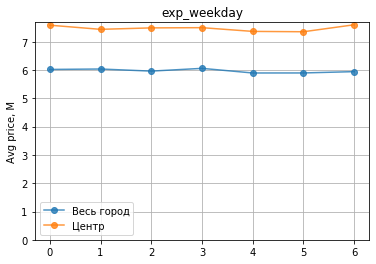

Корреляция exp_weekday 0.48596678544179384


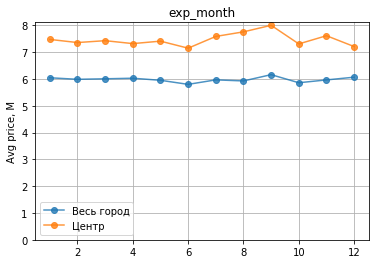

Корреляция exp_month 0.49927973577005874


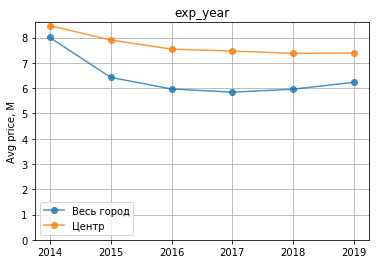

Корреляция exp_year 0.9409634521104333


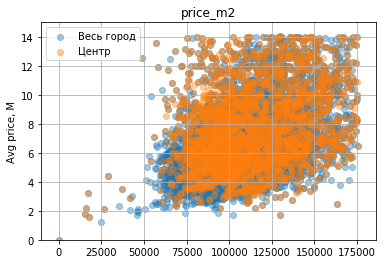

Корреляция price_m2 0.9225381486192362


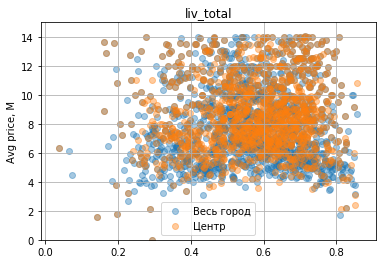

Корреляция liv_total 0.9080523696424174


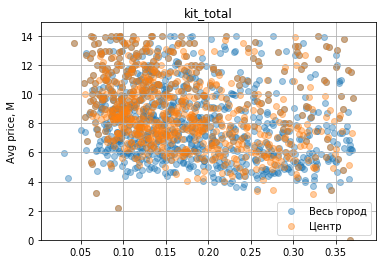

Корреляция kit_total 0.9236788527649048


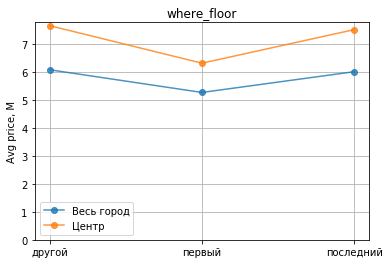

Корреляция where_floor 0.9997991799476178


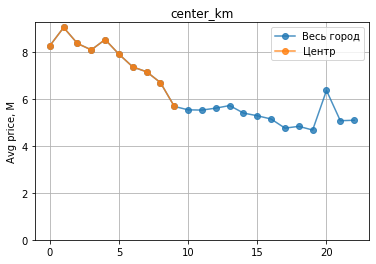

Корреляция center_km 1.0


In [ ]:
for column in spb.select_dtypes(['int64', 'float64', 'object']):
    if column in ['last_price', 'loc_id']:
        continue
    scat_flag = False
    alp = 0.8
    column_filter = 'last_price_filtered'
    if column + '_filtered' in spb.columns:
        column_filter = 'last_price_filtered' + ' and ' + column + '_filtered'
    if spb[column].dtype == 'float64':
        scat_flag = True
        alp = 0.4
    plot_comp(spb.query(column_filter), column, scatter=scat_flag, alpha_=alp)


Взглянем так же на разницу матриц корреляции для объявлений во всм городе и объявлений в центре, чтобы найти самые различающиеся поля:

In [ ]:
columns_filter = 'last_price_filtered'
column_list = ['last_price']
for column in spb.select_dtypes(['int64', 'float64', 'object']):
    if column in ['last_price', 'loc_id']:
        continue
    
    if column + '_filtered' in spb.columns:
        columns_filter += f" and {column}_filtered"
        column_list.append(column)

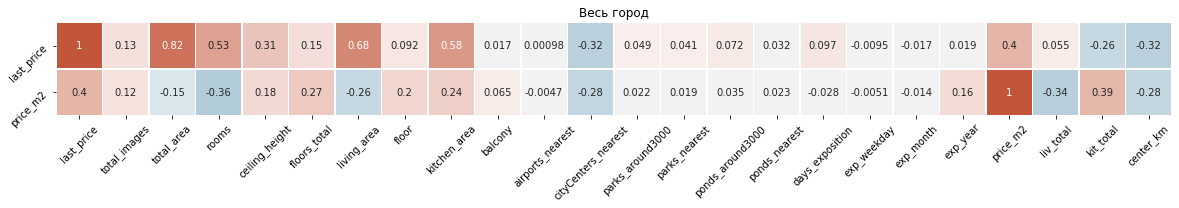

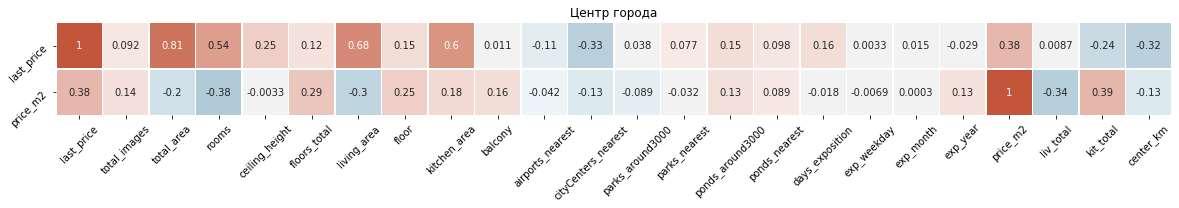

In [ ]:
x_center = spb.query('is_center and ' + columns_filter)[column_list]
x_all = spb.query(columns_filter)[column_list]


plt.figure(figsize=(20,12))
plt.title('Весь город')
sns.heatmap(x_all.corr()[['last_price', 'price_m2']].T, 
            cmap=cmap, 
            center=0, 
            square=True, 
            linewidths=.5, 
            annot=True,
            cbar = None)
plt.yticks(rotation=45)
plt.xticks(rotation=45)
plt.show()
plt.figure(figsize=(20,12))
plt.title('Центр города')
sns.heatmap(x_center.corr()[['last_price', 'price_m2']].T, 
            cmap=cmap, 
            center=0, 
            square=True, 
            linewidths=.5, 
            annot=True,
            cbar = None)
plt.yticks(rotation=45)
plt.xticks(rotation=45)
plt.show()
plt.close()

Как мы видим, сильных отличий в образовании цены квартиры в центре не имеют.



---





# Выводы
<a name='end'></a>
<a id='end'></a>

Мы выяснили, что на цену квартиры влияет несколько метрик, влияение которых разное в зависимости от нахождения в СПб и в его центре.

Так, больше всего на цену влияет площадь квартиры (что соотносится с количеством комнат, но в области цена начинает падать после 6 комнаты, тогда как в Питере продолжает расти). Так же на стоимость влияет удалённость от центра города - чем ближе - тем дороже. Нахождение на первом этаже снижает стоимость квартиры больше чем на миллион в центре Питера и почти на пол миллиона в среднем по области. Каждый год в июне и октябре цены немного снижаются (примерно одинаково в любом месте) (возможно, связано с сезоном отпусков), так же в центре цены немного снижаются к новому году. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=73c6fdc9-2380-4d92-b495-95da9dd36eb1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>